<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Example:-Examine-Potentials" data-toc-modified-id="Example:-Examine-Potentials-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Example: Examine Potentials</a></span></li><li><span><a href="#Example:-Creating-Simulation-Information" data-toc-modified-id="Example:-Creating-Simulation-Information-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Example: Creating Simulation Information</a></span></li><li><span><a href="#Example:-Make-Simulation-Script" data-toc-modified-id="Example:-Make-Simulation-Script-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Example: Make Simulation Script</a></span></li></ul></div>

In [1]:
import numpy as np
import utils
import matplotlib.pyplot as plt
%matplotlib inline

# Example: Examine Potentials

In [2]:
from utils import LAMMPS

In [3]:
r_, u_, f_ = LAMMPS.force_shifted_lennard_jones(
    r_min=0.7, r_cut=2.5, eps=1.0, sigma=1.0, alpha=6, bins=1000)

(-3.5, 3.5)

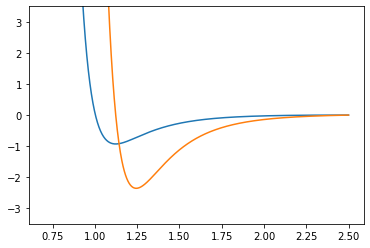

In [4]:
plt.plot(r_, u_, color='C0')
plt.plot(r_, f_, color='C1')
plt.ylim(-3.5, 3.5)

In [21]:
r_, u_, f_ = LAMMPS.force_shifted_yukawa(
    r_min=0, r_cut=2.5, eps=1.0, kappa=5.0, bins=1000)

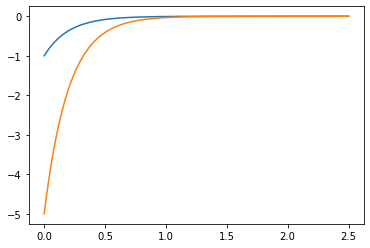

In [23]:
plt.plot(r_, u_, color='C0')
plt.plot(r_, f_, color='C1')

In [37]:
sig = 1.0
kappa_sig = 2.5
r_, u_, f_ = LAMMPS.force_shifted_tanh(
    
    r_min=0, r_cut=2.5*sig, eps=-1.0, sigma=sig, kappa=kappa_sig/sig, bins=1000)

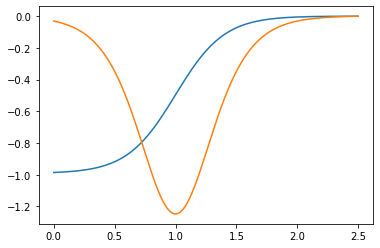

In [38]:
plt.plot(r_, u_, color='C0')
plt.plot(r_, f_, color='C1')

# Example: Creating Simulation Information

In [39]:
# Step 1: Load Colloid from C++ code
from utils import Colloid

c = Colloid()
c.load(
    filename='../examples/initialize_colloid/colloid.json'
)

# Scale so motif points are "at contact" - also sets "diameters"
# of the beads when using inplace=True
scale_constant = c.scale(inplace=True) 

# Always save the Colloid object so you have the mapping of types
c.save('colloid.pkl')

In [40]:
# Step 2a: Create a mixture of a set of different enantiomorphs
from utils import LAMMPS

buffer = 1.0 # Gap around colloids
box = [30, 30] # Box widths
n_each = [8, 8] # Number of each chirality [same, opposite]

coords_, types_, bbox_ = LAMMPS.tile(c, box, buffer, n=n_each)

In [41]:
# For rigid bodies, LAMMPS needs to know how "big" the rigid body is
# See: https://docs.lammps.org/fix_rigid.html (using rigid/npt/small)
# The comm_modify command will be used to make sure the cutoff is
# at least the "diameter" of the particle to ensure this works
# correctly.
pseudo_diameter = np.sqrt(np.sum((bbox_[:,1] - bbox_[:,0])**2))

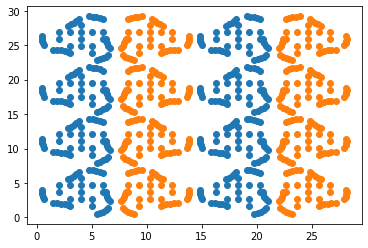

In [42]:
# Step 2b: Let's color by chirality
from utils import Analysis

l = len(c.coords)
end = l
while end <= len(coords_):
    x = Analysis.identify_chirality(
        Analysis.unwrap(c.coords, box), 
        Analysis.unwrap(coords_[end-l:end], box)
    )

    plt.plot(coords_[end-l:end,0], coords_[end-l:end,1], 'o', color='C{}'.format(int(not x)))
    end += l

In [43]:
# Step 3: Turn that into a LAMMPS file to read
pseudo_diameter = LAMMPS.create_initial_configuration(
    c, 
    box, 
    buffer, 
    n_each, 
    'init_config.lammps'
)

In [45]:
# Step 4: Record the potential for each pair of particles
LAMMPS.tabulate_potentials(
    c,
    filename='potentials.lammps', 
    alpha=6, 
    kappa_sigma=2.5,
    bins=50,
    style='fstanh'
)

# Example: Make Simulation Script